In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error

In [2]:
device = torch.device('cpu')
device

device(type='cpu')

In [3]:
ticker = 'AMZN'
df = yf.download(ticker,'2020-01-01')
dff = yf.download(ticker,'2020-01-01')

/var/folders/yv/q6qk8hl51wl7w995rj9w0kx80000gn/T/ipykernel_79516/2875434426.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker,'2020-01-01')
[*********************100%***********************]  1 of 1 completed
/var/folders/yv/q6qk8hl51wl7w995rj9w0kx80000gn/T/ipykernel_79516/2875434426.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dff = yf.download(ticker,'2020-01-01')
[*********************100%***********************]  1 of 1 completed


In [4]:
df

Price,Close,High,Low,Open,Volume
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN
Date,,,,,
2020-01-02,94.900497,94.900497,93.207497,93.750000,80580000
2020-01-03,93.748497,94.309998,93.224998,93.224998,75288000
2020-01-06,95.143997,95.184502,93.000000,93.000000,81236000
2020-01-07,95.343002,95.694504,94.601997,95.224998,80898000
2020-01-08,94.598503,95.550003,94.321999,94.902000,70160000
...,...,...,...,...,...
2025-10-31,244.220001,250.500000,243.979996,250.100006,166340800
2025-11-03,254.000000,258.600006,252.899994,255.360001,95997800


<Axes: xlabel='Date'>

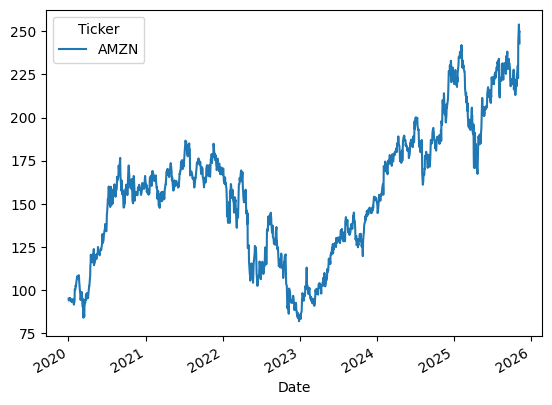

In [5]:
df.Close.plot()

In [6]:
scaler = StandardScaler()

df['Close'] = scaler.fit_transform(df['Close'])

In [7]:
df

Price,Close,High,Low,Open,Volume
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN
Date,,,,,
2020-01-02,-1.593148,94.900497,93.207497,93.750000,80580000
2020-01-03,-1.622865,94.309998,93.224998,93.224998,75288000
2020-01-06,-1.586867,95.184502,93.000000,93.000000,81236000
2020-01-07,-1.581733,95.694504,94.601997,95.224998,80898000
2020-01-08,-1.600938,95.550003,94.321999,94.902000,70160000
...,...,...,...,...,...
2025-10-31,2.258659,250.500000,243.979996,250.100006,166340800
2025-11-03,2.510941,258.600006,252.899994,255.360001,95997800


In [8]:
dff

Price,Close,High,Low,Open,Volume
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN
Date,,,,,
2020-01-02,94.900497,94.900497,93.207497,93.750000,80580000
2020-01-03,93.748497,94.309998,93.224998,93.224998,75288000
2020-01-06,95.143997,95.184502,93.000000,93.000000,81236000
2020-01-07,95.343002,95.694504,94.601997,95.224998,80898000
2020-01-08,94.598503,95.550003,94.321999,94.902000,70160000
...,...,...,...,...,...
2025-10-31,244.220001,250.500000,243.979996,250.100006,166340800
2025-11-03,254.000000,258.600006,252.899994,255.360001,95997800


Can see Close price is now scaled

Goal is to be able to use data over any period of time to predict the stock price. So LSTM is best option

In [9]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)

Each window has 30 days. It is a sliding window of stock Close values starting from day 0 to day 29. Keep doing this until there is no more room.

In [10]:
type(data)

numpy.ndarray

In [11]:
train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size, : -1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [12]:
y_train

tensor([[-1.2683],
        [-1.2876],
        [-1.2608],
        ...,
        [ 0.4834],
        [ 0.5904],
        [ 0.7187]])

Have our data in tensors

In [13]:
class PredictionModel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel,self).__init__()

        self.num_layers =num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim,hidden_dim,num_layers,batch_first=True)
        self.fc = nn.Linear(hidden_dim,output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn,cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:,-1,:])

        return out

In [14]:
model = PredictionModel(input_dim=1, hidden_dim= 32, num_layers=2, output_dim=1).to(device)

In [15]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [16]:
num_epochs = 200

for i in range(num_epochs):
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, y_train)

    if i % 25 == 0:
        print(i,loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


0 0.746364951133728
25 0.018870346248149872
50 0.0113636814057827
75 0.0098275076597929
100 0.0088962959125638
125 0.008172278292477131
150 0.007542636711150408
175 0.007053801789879799


In [17]:
model.eval()

y_test_pred = model(X_test)

In [18]:
print(y_test_pred)
print(y_test_pred.size())

tensor([[0.6765],
        [0.7578],
        [0.7688],
        [0.7340],
        [0.7524],
        [0.7550],
        [0.8131],
        [0.8646],
        [0.9169],
        [0.9349],
        [0.9135],
        [0.8786],
        [0.8109],
        [0.7583],
        [0.7238],
        [0.7100],
        [0.6581],
        [0.7226],
        [0.6497],
        [0.6518],
        [0.7031],
        [0.7488],
        [0.7989],
        [0.7926],
        [0.7866],
        [0.7702],
        [0.7753],
        [0.8038],
        [0.8162],
        [0.8290],
        [0.7455],
        [0.7410],
        [0.7724],
        [0.7953],
        [0.8426],
        [0.8906],
        [0.7989],
        [0.9444],
        [0.9804],
        [1.0384],
        [1.1636],
        [1.2547],
        [1.2681],
        [1.2471],
        [1.2580],
        [1.3256],
        [1.3324],
        [1.2167],
        [1.1337],
        [1.1448],
        [1.1353],
        [1.0649],
        [1.0131],
        [1.0623],
        [1.1761],
        [1

Need to inverse the scaler transformation and turn the tensor back into anumpy array, so we can compare the predictated data to the actual data

In [19]:
y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())


In [20]:
y_test_pred.shape

(289, 1)

In [21]:
train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:,0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])

In [22]:
train_rmse

3.18428635597229

In [23]:
test_rmse

7.514862537384033

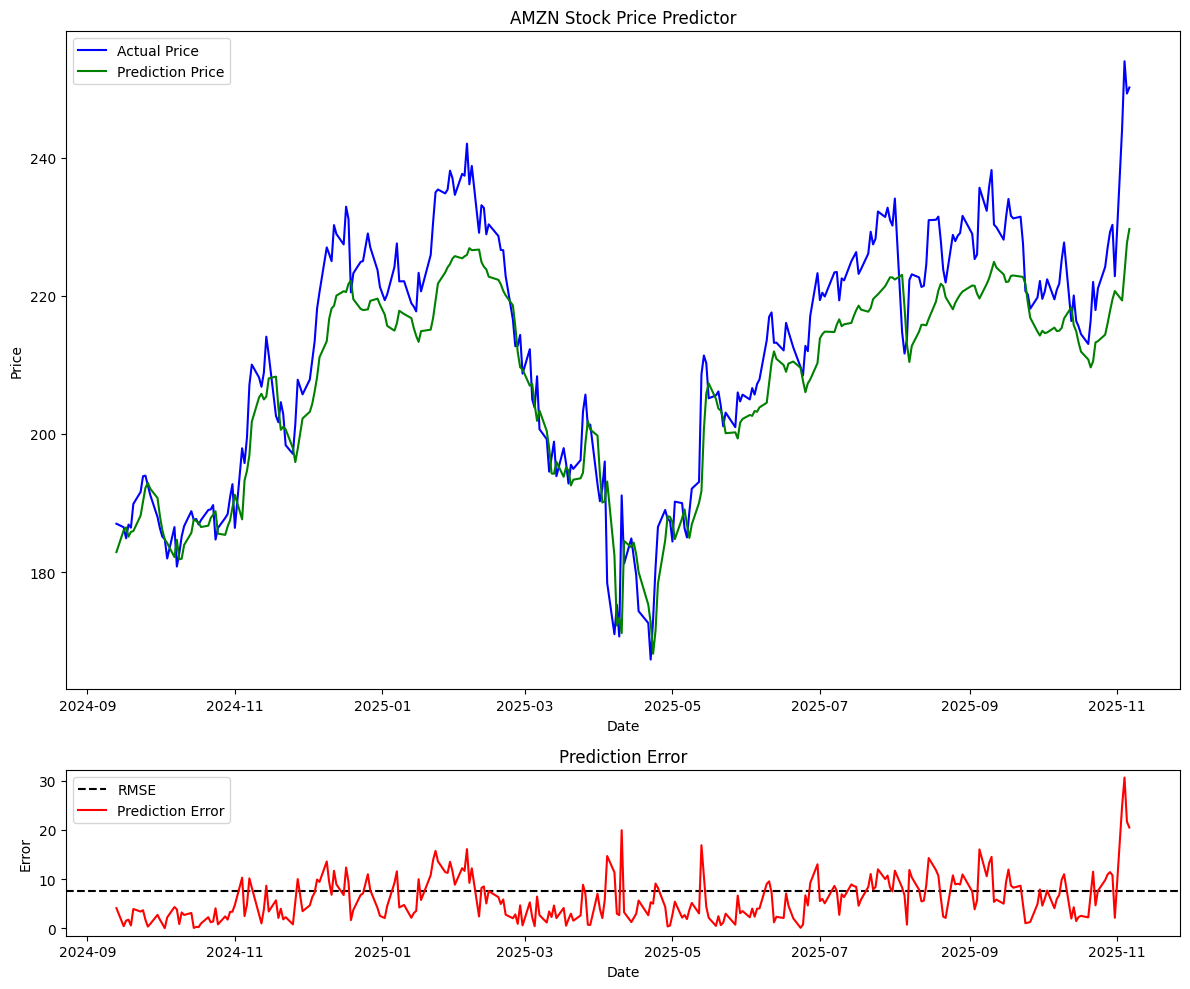

In [24]:
graph = plt.figure(figsize=(12,10))

gs = graph.add_gridspec(4,1)
axl = graph.add_subplot(gs[:3,0])

axl.plot(df.iloc[-len(y_test):].index, y_test, color = 'blue', label = 'Actual Price')
axl.plot(df.iloc[-len(y_test):].index, y_test_pred, color = 'green', label = 'Prediction Price')
axl.legend()

plt.title(f"{ticker} Stock Price Predictor")
plt.xlabel('Date')
plt.ylabel('Price')

ax2 = graph.add_subplot(gs[3,0])
ax2.axhline(test_rmse, color = 'black', linestyle = '--', label = 'RMSE')
ax2.plot(df[-len(y_test):].index, abs(y_test - y_test_pred), 'red', label = 'Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')

plt.tight_layout()
plt.show()

In [25]:
X_test

tensor([[[0.7070],
         [0.2899],
         [0.1125],
         ...,
         [0.4834],
         [0.5904],
         [0.7187]],

        [[0.2899],
         [0.1125],
         [0.1359],
         ...,
         [0.5904],
         [0.7187],
         [0.7826]],

        [[0.1125],
         [0.1359],
         [0.1576],
         ...,
         [0.7187],
         [0.7826],
         [0.7695]],

        ...,

        [[1.6522],
         [1.6393],
         [1.5862],
         ...,
         [1.8996],
         [1.7077],
         [2.2587]],

        [[1.6393],
         [1.5862],
         [1.6282],
         ...,
         [1.7077],
         [2.2587],
         [2.5109]],

        [[1.5862],
         [1.6282],
         [1.6899],
         ...,
         [2.2587],
         [2.5109],
         [2.3902]]])

In [26]:
print(X_test.size())

torch.Size([289, 29, 1])


In [27]:
X_test = scaler.inverse_transform(X_test.detach().cpu().numpy())

ValueError: Found array with dim 3, while dim <= 2 is required.

In [ ]:
X_test

array([[[1.035119  ],
        [1.0555345 ],
        [1.1472923 ],
        ...,
        [1.3411254 ],
        [1.2594652 ],
        [1.2923925 ]],

       [[1.0555345 ],
        [1.1472923 ],
        [1.1659514 ],
        ...,
        [1.2594652 ],
        [1.2923925 ],
        [1.059925  ]],

       [[1.1472923 ],
        [1.1659514 ],
        [1.0895591 ],
        ...,
        [1.2923925 ],
        [1.059925  ],
        [1.015143  ]],

       ...,

       [[0.94136333],
        [1.1691847 ],
        [1.3187128 ],
        ...,
        [1.5450137 ],
        [1.6342145 ],
        [1.6922829 ]],

       [[1.1691847 ],
        [1.3187128 ],
        [1.5242594 ],
        ...,
        [1.6342145 ],
        [1.6922829 ],
        [1.724298  ]],

       [[1.3187128 ],
        [1.5242594 ],
        [1.4820875 ],
        ...,
        [1.6922829 ],
        [1.724298  ],
        [1.7428448 ]]], shape=(282, 29, 1), dtype=float32)

In [ ]:
X_test = scaler.inverse_transform(X_test)  

ValueError: Found array with dim 3, while dim <= 2 is required.

In [ ]:
X_test

array([[[-0.06220452],
        [-0.05152893],
        [-0.05610421],
        ...,
        [ 0.06031117],
        [ 0.0659031 ],
        [ 0.06539473]],

       [[-0.05152893],
        [-0.05610421],
        [-0.05051218],
        ...,
        [ 0.0659031 ],
        [ 0.06539473],
        [ 0.05878604]],

       [[-0.05610421],
        [-0.05051218],
        [-0.06627148],
        ...,
        [ 0.06539473],
        [ 0.05878604],
        [ 0.06793661]],

       ...,

       [[ 3.5265906 ],
        [ 3.6859624 ],
        [ 3.7535748 ],
        ...,
        [ 3.3001144 ],
        [ 3.4798207 ],
        [ 3.474229  ]],

       [[ 3.6859624 ],
        [ 3.7535748 ],
        [ 3.8745658 ],
        ...,
        [ 3.4798207 ],
        [ 3.474229  ],
        [ 3.4500816 ]],

       [[ 3.7535748 ],
        [ 3.8745658 ],
        [ 3.7657754 ],
        ...,
        [ 3.474229  ],
        [ 3.4500816 ],
        [ 3.4010246 ]]], shape=(244, 29, 1), dtype=float32)

In [ ]:
def to_np(x):
    return x.detach().cpu().numpy() if torch.is_tensor(x) else np.asarray(x)

# flatten targets/preds to 1-D
y_true = to_np(y_test).reshape(-1)
y_hat  = to_np(y_test_pred).reshape(-1)

X_np   = scaler.inverse_transform(X_test)              


# Baselines
last        = X_np[:, -1, 0]                          # persistence
y_naive     = last
y_naive_ar1 = last + (last - X_np[:, -2, 0])          # carry-forward last change
y_sma30     = X_np[:, :, 0].mean(axis=1)              # simple moving average

# Metrics
rmse = lambda a,b: root_mean_squared_error(a, b)
mae  = lambda a,b: mean_absolute_error(a, b)

print("RMSE LSTM :", rmse(y_true, y_hat))
print("RMSE Naive:", rmse(y_true, y_naive))
print("RMSE AR1  :", rmse(y_true, y_naive_ar1))
print("RMSE SMA  :", rmse(y_true, y_sma30))

improve = 100 * (rmse(y_true, y_naive) - rmse(y_true, y_hat)) / rmse(y_true, y_naive)
print(f"Improvement vs Naive: {improve:.1f}%")

# Directional (up/down) accuracy vs last price
true_up = y_true > last
lstm_up = y_hat  > last
ar1_up  = y_naive_ar1 > last
print(f"Directional hit LSTM: {(lstm_up == true_up).mean()*100:.1f}%")
print(f"Directional hit AR1 : {(ar1_up  == true_up).mean()*100:.1f}%")

ValueError: Found array with dim 3, while dim <= 2 is required.